In [1]:
!pip install yfinance
!pip install bs4
!pip install requests
!pip install ta
!pip install finta
!pip install mplfinance
import pandas as pd
import requests
from datetime import datetime
import yfinance as yf
from bs4 import BeautifulSoup
import numpy as np
import math
import mplfinance as mpf

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=93c0af5501a769f699ca1e91c13ef39d30974974768c0d8064e5ab05e7ec9a41
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [4]:
import random

def index(n = 5):
  '''n=5: 한달에 몇 개 일자, 최대 5 (넘으면 **휴장일**땜에 *버*그*폭*발* 제핳하핳ㅎㅎㅎㅏㅏㅏㅏㅏㅏfffffffffffffffffff)'''
  if n > 5:
    raise Exception(f"n값 5 넘기면 휴장일 때문에 버그, input n: {n}")

  time_series = pd.read_csv('https://docs.google.com/spreadsheets/d/1hT_dDp1dry2SUU96tyjQwgsl45KrGQGVJG2rK6EYZCg/gviz/tq?tqx=out:csv&sheet=sheet1')
  time_series['Date'] = pd.to_datetime(time_series["Date"])
  time_series = time_series['Date'].tolist()
  year_range = time_series[-1].year - time_series[0].year
  year = time_series[0].year

  li = []
  for i in range(year_range + 1):
    for month in range(1, 13):
      month = str(month)
      for howmany in range(n):
        stack = 0
        k = 1
        if month==2 and howmany != 0:
          k=-1
        while True:
          # stack += 1
          # if stack > 10:
          #   print(i, month, rn, howmany)
          #   break
          rn = str(random.randint(30//n*howmany+k, 30//n*(howmany+1)))
          try:
            x = pd.Timestamp(str(year+i)+"-"+month+"-"+rn)
          except:
            continue
          if pd.Timestamp(str(year+i)+"-"+month+"-"+rn) in time_series:
            break

        li.append(pd.Timestamp(str(year+i)+"-"+str(month)+"-"+rn))
  return li

In [7]:
k = 1

screened_list = []
stock_list = ['AAPL']
for stock_code in stock_list:
  # get stock prices
  df = pd.read_csv("drive/MyDrive/확률통계론_프로젝트/df/NASDAQ/GOOG.csv", encoding='utf-8-sig')
  df["Date"] = pd.to_datetime(df["Date"])
  df = df.set_index("Date")
  df = df.loc[index(k)]
  # df.columns.names = [None, None]
  # df = df.droplevel(level=1,axis=1)

  # parameter setup

  length_li = [6, 11, 16, 21, 26]
  mult_li = [1.2, 1, 0.9, 0.8, 0.7]
  length = length_li[k-1]
  mult = 1.5 * mult_li[k-1]
  length_KC = length_li[k-1]
  mult_KC = 1.5

  # calculate BB
  m_avg = df['Close'].rolling(window=length).mean()
  m_std = df['Close'].rolling(window=length).std(ddof=0)
  df['upper_BB'] = m_avg + mult * m_std
  df['lower_BB'] = m_avg - mult * m_std

  # calculate true range
  # https://alphasquare.co.kr/home/insight/posts/fcb90857-9485-44c5-9b95-49266c42410f
  # https://www.jaenung.net/tree/21667
  # https://medium.com/geekculture/implementing-the-most-popular-indicator-on-tradingview-using-python-239d579412ab
  df['tr0'] = abs(df["High"] - df["Low"])
  df['tr1'] = abs(df["High"] - df["Close"].shift())
  df['tr2'] = abs(df["Close"] - df["Low"].shift())
  df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)  #

  # calculate KC
  range_ma = df['tr'].rolling(window=length_KC).mean()
  df['upper_KC'] = m_avg + range_ma * mult_KC
  df['lower_KC'] = m_avg - range_ma * mult_KC

  # calculate bar value
  highest = df['High'].rolling(window = length_KC).max()
  lowest = df['Low'].rolling(window = length_KC).min()
  m1 = (highest + lowest)/2
  df['value'] = (df['Close'] - (m1 + m_avg)/2)
  fit_y = np.array(range(0,length_KC))
  df['value'] = df['value'].rolling(window = length_KC).apply(lambda x:
                            np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
                            np.polyfit(fit_y, x, 1)[1], raw=True)






  # check for 'squeeze'
  df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
  df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])
  df['nosqz'] = (df['squeeze_off']==False) & (df['squeeze_on']==False)

  # buying window for long position:
  # 1. black cross becomes gray (the squeeze is released)
  long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
  # 2. bar value is positive => the bar is light green k
  long_cond2 = df['value'][-1] > 0
  enter_long = long_cond1 and long_cond2

  # buying window for short position:
  # 1. black cross becomes gray (the squeeze is released)
  short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
  # 2. bar value is negative => the bar is light red
  short_cond2 = df['value'][-1] < 0
  enter_short = short_cond1 and short_cond2

  if enter_long | enter_short:
      screened_list.append(stock_code)

if screened_list:
  print(screened_list)
else:
  print('No stock fits the Squeeze Momentum Indicator entry requirement')

No stock fits the Squeeze Momentum Indicator entry requirement


/tmp/ipython-input-7-2986340950.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
/tmp/ipython-input-7-2986340950.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  long_cond2 = df['value'][-1] > 0
/tmp/ipython-input-7-2986340950.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][

/tmp/ipython-input-8-2952037241.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if val < df['value'][ind-1]:
/tmp/ipython-input-8-2952037241.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if val > df['value'][ind-1]:


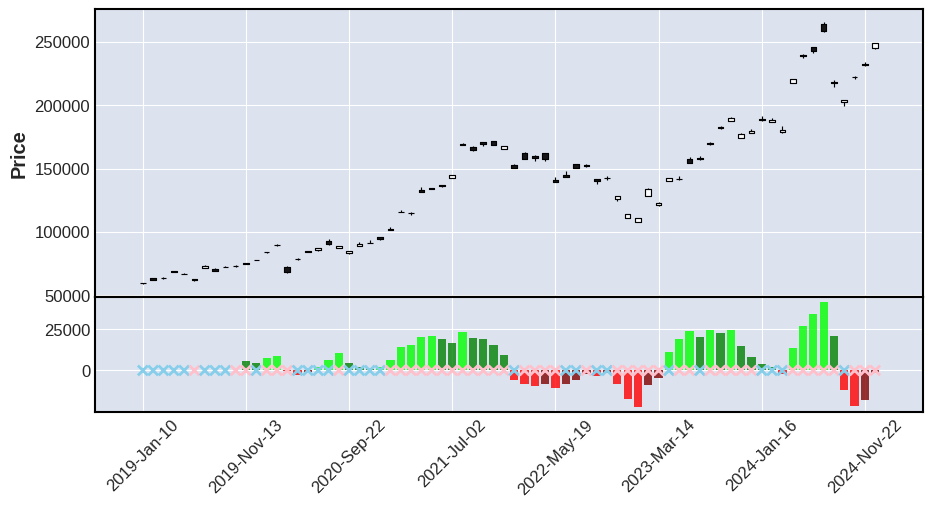

In [8]:
# extract only ['Open', 'High', 'Close', 'Low'] from df
ohcl = df[['Open', 'High', 'Close', 'Low']]

# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df['value']):
  if val >= 0:
    color = 'green'
    if val > df['value'][ind-1]:
      color = 'lime'
  else:
    color = 'maroon'
    if val < df['value'][ind-1]:
      color='red'
  colors.append(color)

# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['pink' if s else 'skyblue' for s in df['squeeze_off']], secondary_y=False)]

# plot ohcl with subplots
fig, axes = mpf.plot(ohcl,
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              addplot=apds,
              returnfig=True)

In [ ]:
df

,Low,Open,Close,High,Volume,upper_BB,lower_BB,tr0,tr1,tr2,tr,upper_KC,lower_KC,value,squeeze_on,squeeze_off,nosqz
Date,,,,,,,,,,,,,,,,,
2019-01-03,91.432415,94.160339,91.620552,94.245002,42579100,NaN,NaN,2.812587,NaN,NaN,2.812587,NaN,NaN,NaN,False,False,True
2019-01-07,94.988126,95.608959,96.004036,97.142237,35656100,NaN,NaN,2.154111,5.521685,4.571621,5.521685,NaN,NaN,NaN,False,False,True
2019-01-17,98.543833,98.769590,99.823135,100.302868,28393000,NaN,NaN,1.759035,4.298832,4.835010,4.835010,NaN,NaN,NaN,False,False,True
2019-01-23,99.089417,99.823140,100.378128,100.688549,25874300,NaN,NaN,1.599131,0.865413,1.834295,1.834295,NaN,NaN,NaN,False,False,True
2019-01-29,96.107518,98.656714,96.831833,98.741377,31490500,NaN,NaN,2.633859,1.636751,2.257585,2.633859,NaN,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05,435.297179,437.043677,441.734253,443.770179,21697800,430.740396,407.848791,8.473001,16.636634,23.722402,23.722402,438.641875,399.947313,5.079170,True,False,False
2024-12-12,448.211258,448.211258,448.660370,455.247169,20834800,433.810115,410.032670,7.035910,13.512916,13.363191,13.512916,441.341867,402.500919,8.249390,True,False,False
2024-12-16,444.388939,446.374947,450.686310,451.275125,23598800,437.119170,410.112416,6.886186,2.614756,2.475052,6.886186,441.787797,405.443789,12.924942,True,False,False


<Figure size 640x480 with 0 Axes>

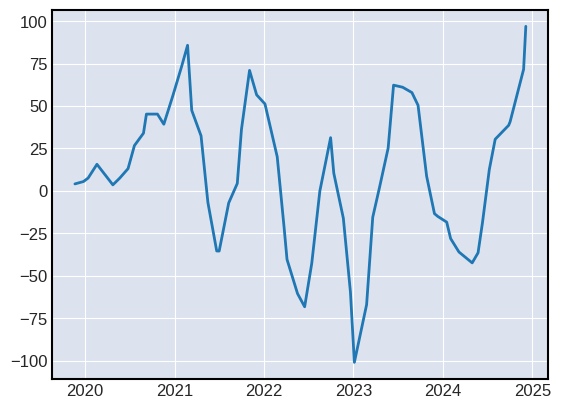

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(index(k), df["value"])
plt.figure()